In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import requests
import json


client_id = 'dc2f1fa6-fb4e-488f-a13e-f2ad8c1edecd'


In [2]:
#Temperatures for: DRAMMEN - BANGELØKKA
endpoint = 'https://frost.met.no/observations/v0.jsonld?sources=SN26580&referencetime=2021-02-01/2021-02-10&elements=air_temperature&timeoffsets=default&levels=default'


# Issue an HTTP GET request
r = requests.get(endpoint, auth=(client_id,''))
# Extract JSON data
result_json = r.json()
data = result_json['data']

In [20]:
data

[{'sourceId': 'SN26580:0',
  'referenceTime': '2021-02-01T00:00:00.000Z',
  'observations': [{'elementId': 'air_temperature',
    'value': -12.3,
    'unit': 'degC',
    'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
    'timeOffset': 'PT0H',
    'timeResolution': 'PT1H',
    'timeSeriesId': 0,
    'performanceCategory': 'E',
    'exposureCategory': '2',
    'qualityCode': 0}]},
 {'sourceId': 'SN26580:0',
  'referenceTime': '2021-02-01T01:00:00.000Z',
  'observations': [{'elementId': 'air_temperature',
    'value': -11.9,
    'unit': 'degC',
    'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
    'timeOffset': 'PT0H',
    'timeResolution': 'PT1H',
    'timeSeriesId': 0,
    'performanceCategory': 'E',
    'exposureCategory': '2',
    'qualityCode': 0}]},
 {'sourceId': 'SN26580:0',
  'referenceTime': '2021-02-01T02:00:00.000Z',
  'observations': [{'elementId': 'air_temperature',
    'value': -11.3,
    'unit': 'degC',
    'level': {'level

In [3]:
#Retrieving the data of interest by looping through every entry of the list
data_tmp = [(entry['referenceTime'], obs['value']) for entry in data for obs in entry['observations']]

#Adding the data_tmp-values to a dataframe called temperature_df
temperature_df = pd.DataFrame(data_tmp, columns=['referenceTime', 'value'])
#Renaming the 'value'-column to 'historical_temperature'
temperature_df.rename(columns={'value':'historical_temperatures'}, inplace=True)

#Making the 'reference_time the datetime index of the dataframe
temperature_df['referenceTime'] = pd.to_datetime(temperature_df['referenceTime'])
temperature_df.set_index('referenceTime', inplace=True)
#Resampling to hourly resolution and interpolating
temperature_df = temperature_df.resample('H').interpolate()


[('2021-02-01T00:00:00.000Z', -12.3), ('2021-02-01T01:00:00.000Z', -11.9), ('2021-02-01T02:00:00.000Z', -11.3), ('2021-02-01T03:00:00.000Z', -11), ('2021-02-01T04:00:00.000Z', -11.1), ('2021-02-01T05:00:00.000Z', -11.2), ('2021-02-01T06:00:00.000Z', -11.3), ('2021-02-01T07:00:00.000Z', -10.9), ('2021-02-01T08:00:00.000Z', -10.9), ('2021-02-01T09:00:00.000Z', -10.5), ('2021-02-01T10:00:00.000Z', -10.2), ('2021-02-01T11:00:00.000Z', -9.8), ('2021-02-01T12:00:00.000Z', -9.3), ('2021-02-01T13:00:00.000Z', -8.9), ('2021-02-01T14:00:00.000Z', -8.5), ('2021-02-01T15:00:00.000Z', -8.7), ('2021-02-01T16:00:00.000Z', -8.6), ('2021-02-01T17:00:00.000Z', -8.7), ('2021-02-01T18:00:00.000Z', -9.6), ('2021-02-01T19:00:00.000Z', -10.7), ('2021-02-01T20:00:00.000Z', -10.7), ('2021-02-01T21:00:00.000Z', -11), ('2021-02-01T22:00:00.000Z', -11.6), ('2021-02-01T23:00:00.000Z', -11.4), ('2021-02-02T00:00:00.000Z', -11.6), ('2021-02-02T01:00:00.000Z', -11.6), ('2021-02-02T02:00:00.000Z', -11.4), ('2021-02-02

In [4]:
temperature_df.head(2)

,historical_temperatures
referenceTime,
2021-02-01 00:00:00+00:00,-12.3
2021-02-01 01:00:00+00:00,-11.9


In [5]:
#Plotting the temperatures

fig = px.line(temperature_df, title='Temperature plot')

# Show the plot
fig.show()


In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

training_start_date = '2021-02-01 00:00:00+00:00'
training_end_date = '2021-02-01 23:00:00+00:00'
predicting_start_date = '2021-02-02 00:00:00+00:00'
predicting_end_date = '2021-02-02 23:00:00+00:00'

# Filter data within the specified datetime range
df_train = temperature_df.loc[training_start_date:training_end_date]
df_test = temperature_df.loc[predicting_start_date:predicting_end_date]


In [7]:
#Plotting the temperatures

fig = px.line(df_test, title='Temperature plot')

# Show the plot
fig.show()


In [8]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.8226401582083595


In [9]:
from statsmodels.tsa.arima.model import ARIMA

def predicting(df_train, df_test, start_date, end_date, p, d, q):
    model = ARIMA(df_train, order=(p,d,q))
    model = model.fit()
    df_test['predictions'] = model.predict(start=start_date, end=end_date, typ='levels')
    df_test[start_date:end_date]

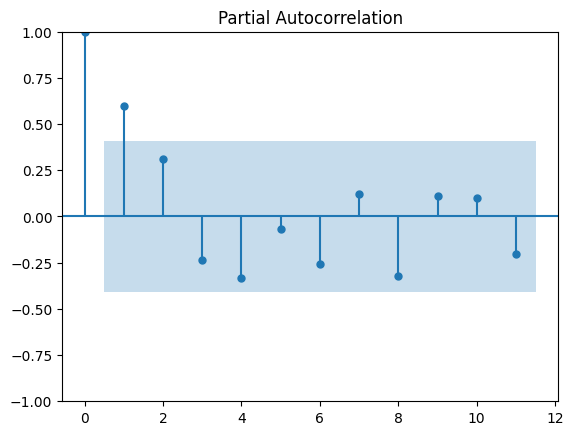

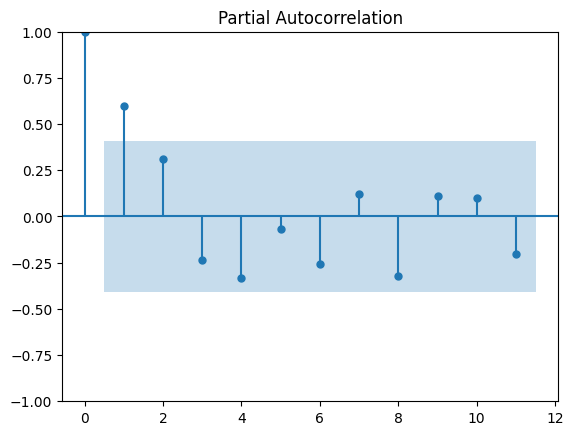

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_test['historical_temperatures'].diff().dropna())

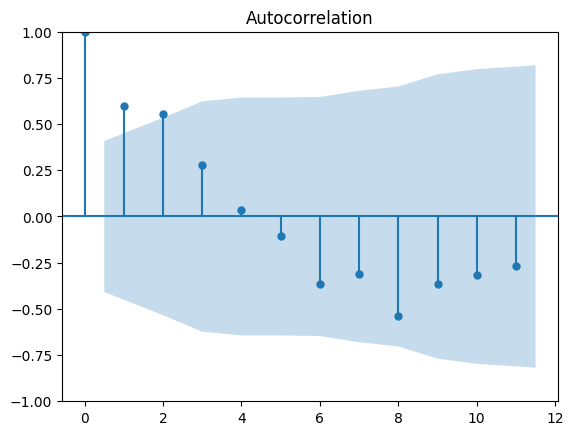

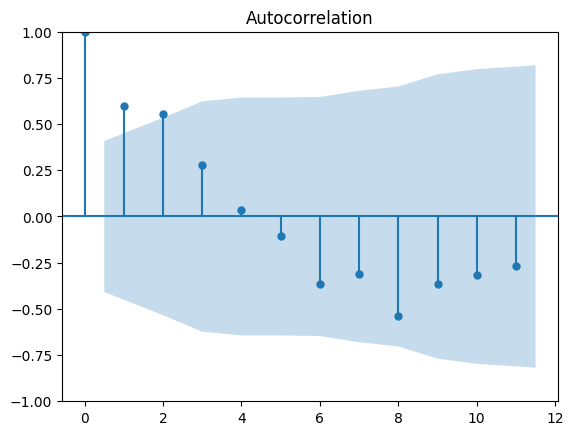

In [11]:
plot_acf(df_test['historical_temperatures'].diff().dropna())

In [12]:
start_date='2021-02-02 00:00:00+00:00'
end_date='2021-02-02 23:00:00+00:00'
p=6
d=1
q=1
#p = number of past values included in the AR model
#d = number of times the time series is differenced
#q = the number of past forecast errors included in the MA model

predicting(df_test=df_test, df_train=df_train, start_date=start_date,end_date=end_date, p=p, d=d, q=q)


c:\Users\even.vehus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\even.vehus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\even.vehus\AppData\Local\Temp\ipykernel_20396\3891012487.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
prediction_fig = px.line()

prediction_fig.add_trace(
                go.Scatter(
                    x=temperature_df.index,
                    y=temperature_df['historical_temperatures']['2021-02-01 00:00:00+00:00':'2021-02-03 09:00:00+00:00'],
                    mode="lines",
                    name='actual historical temperatures',
                    line=dict(color="blue"),
                )
            )
prediction_fig.add_trace(
                go.Scatter(
                    x=df_test.index,
                    y=df_test['predictions'],
                    mode="lines",
                    name='Predictions',
                    line=dict(color="green"),
                )
            )
prediction_fig.show()


In [14]:

difference = df_test['predictions'] - df_test['historical_temperatures']
difference_plot = px.line(df_test['predictions'] - df_test['historical_temperatures'])
difference_plot.show()

In [15]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -14.019
Date:                Mon, 12 Feb 2024   AIC                             34.039
Time:                        08:23:56   BIC                             37.573
Sample:                    02-01-2021   HQIC                            34.976
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.012     83.967      0.000       0.975       1.022
ma.L1          0.5441      0.192      2.841      0.004       0.169       0.920
sigma2         0.1392      0.063      2.201      0.028       0.015       0.263
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.92   Prob(JB):                         0.41
Heteroskedasticity (H):               2.79   Skew:                            -0.47
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

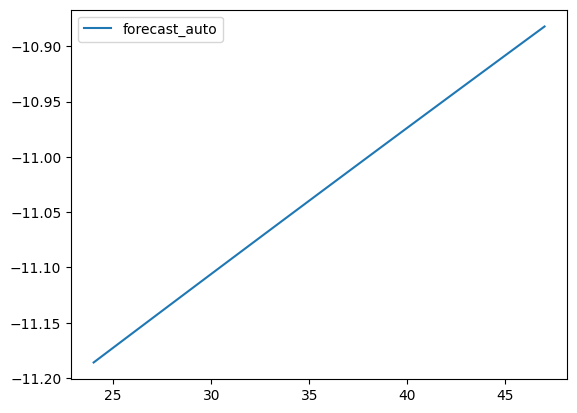

In [17]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))

df = pd.DataFrame()
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)
df.plot()

## Monte Carlo Simulation

In [18]:
import numpy as np

def monte_carlo_simulation(df_train, df_test, start_date, end_date, p, d, q, num_simulations):

    montecarlofig = px.line()

    for i in range(num_simulations):


        p_variation = np.random.randint(-1, 2) 
        d_variation = np.random.randint(-1, 2)
        q_variation = np.random.randint(-1, 2)
    
        model = ARIMA(df_train, order=(p + p_variation, d + d_variation, q + q_variation))
        model = model.fit()

        df_test[f'Simulation_{i + 1}'] = model.predict(start=start_date, end=end_date, typ='levels')


        montecarlofig.add_trace(
                go.Scatter(
                    x=df_test.index,
                    y=df_test[f'Simulation_{i + 1}'],
                    mode="lines",
                    name=f'Simulation_{i + 1}',
                    line=dict(color="green"),
                )
            )
        
    montecarlofig.add_trace(
    go.Scatter(
        x=df_test.index,
        y=df_test['predictions'],
        mode="lines",
        name=f'Initial prediction',
        line=dict(color="red"),
        )
    )
    montecarlofig.add_trace(
    go.Scatter(
        x=df_test.index,
        y=df_test['historical_temperatures'],
        mode="lines",
        name=f'Historical data',
        line=dict(color="blue"),
        )
    )
        

    montecarlofig.show()

In [19]:
monte_carlo_simulation(df_train, df_test, start_date, end_date, p=1, d=1, q=1, num_simulations=1000)

c:\Users\even.vehus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\even.vehus\AppData\Local\Temp\ipykernel_20396\3916501781.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\even.vehus\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\even.vehus\AppData\Local\Temp\ipykernel_20396\3916501781.py:17: SettingWithCop